In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1, 2, 3"
import monai.transforms as tf
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
# import numpy as np
# import pandas as pd
# import nibabel as nib
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
# from copy import copy
from shutil import rmtree
from tqdm import tqdm
from torch.utils import data
import numpy as np
import random

import monai.transforms as tf
from monai.losses import DiceLoss, DiceCELoss
from monai.networks.nets import UNet, UNETR, DynUNet, SegResNet
from monai.networks.layers import Norm
# from monai.networks import one_hot
from utils.Utils import concat_bg
from utils.Metric import compute_meandice, compute_meandice_multilabel

from utils.Device import *
from utils.Data import load_dataloader, convert_label_to_brats
from utils.Loss import *
from utils.Gradient import plot_grad_flow
from utils.Visualize import plot_whole_imgs
from utils.Model import load_model_weights
from utils.Metric import Score

from datetime import datetime
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
import numpy as np
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    ToDeviced
)
from monai.utils import set_determinism

import torch

print_config()


MONAI version: 0.8.0
Numpy version: 1.21.2
Pytorch version: 1.10.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: 0.4.6
Nibabel version: 3.2.1
scikit-image version: 0.18.3
Pillow version: 8.4.0
Tensorboard version: 2.7.0
gdown version: 4.2.0
TorchVision version: 0.11.1
tqdm version: 4.62.3
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.3.4
einops version: 0.3.2
transformers version: 4.15.0
mlflow version: 1.22.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
random_seed = 2022
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
#torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)
# enable cuDNN benchmark
#torch.backends.cudnn.benchmark = True

In [9]:
# Get Environment variables
batch_size_train = 4
batch_size_test = 4
root_dir = "/cluster/projects/mcintoshgroup/BraTs2020/data_monai/"
ckpt_save_dir = "result/"
num_epochs = 10
augmentation = False


In [10]:
# train transforms
# Add augmentation
if augmentation:
    print("aug")
    train_transforms = tf.Compose([
        tf.LoadImaged(reader="NibabelReader", keys=['image', 'label']),
        tf.OneOf([
            tf.RandGaussianNoised(keys=["image"], prob=0.4, mean=0, std=1.0),  # 0.8 x 0.5
            tf.RandRotated(keys=["image", "label"], prob=0.4, range_x=(-90, 90)),  # 0.8 x 0.5
            tf.RandFlipd(keys=["image", "label"], prob=0.4, spatial_axis=0),  # 0.8 x 0.5
        ]),
        tf.EnsureTyped(keys=["image", "label"]),
        tf.ToTensord(keys=['image', 'label']),
        tf.ToDeviced(keys=["image", "label"], device="cuda:0"),
        tf.DeleteItemsd(keys=["image_transforms", "label_transforms"])
    ])
    
else:
    print('no aug')
    train_transforms = tf.Compose([
        tf.LoadImaged(reader="NibabelReader", keys=['image', 'label']),
        #tf.EnsureTyped(keys=["image", "label"]),
        tf.ToTensord(keys=['image', 'label']),
        tf.ToDeviced(keys=["image", "label"], device="cuda:0"),
    ])

# validation and test transforms
val_transforms = tf.Compose([
    tf.LoadImaged(reader="NibabelReader", keys=['image', 'label']),
    #tf.EnsureTyped(keys=["image", "label"]),
    tf.ToTensord(keys=['image', 'label']),
    tf.ToDeviced(keys=["image", "label"], device="cuda:0")
])

no aug


In [ ]:
loader_params = dict(
    batch_size=batch_size_train,
    shuffle=True
)

test_loader_params = dict(
    batch_size=batch_size_test,
    shuffle=False
)

train_dataloader = load_dataloader(root_dir, "train", train_transforms, loader_params)
print(len(train_dataloader))
valid_dataloader = load_dataloader(root_dir, "valid", val_transforms, test_loader_params)
print(len(valid_dataloader))
test_dataloader = load_dataloader(root_dir, "test", val_transforms, test_loader_params)
print(len(test_dataloader))

In [7]:
for batch_idx, batch in enumerate(train_dataloader):
    inputs, labels = batch["image"], convert_label_to_brats(concat_bg(batch["label"]))
    print("input shape: ",inputs.shape)
    print("label shape: ",labels.shape)
    if (batch_idx==5):
        break;


input shape:  torch.Size([4, 4, 240, 240])
label shape:  torch.Size([4, 4, 240, 240])
input shape:  torch.Size([4, 4, 240, 240])
label shape:  torch.Size([4, 4, 240, 240])
input shape:  torch.Size([4, 4, 240, 240])
label shape:  torch.Size([4, 4, 240, 240])
input shape:  torch.Size([4, 4, 240, 240])
label shape:  torch.Size([4, 4, 240, 240])
input shape:  torch.Size([4, 4, 240, 240])
label shape:  torch.Size([4, 4, 240, 240])
input shape:  torch.Size([4, 4, 240, 240])
label shape:  torch.Size([4, 4, 240, 240])


In [8]:
max_epochs = 30
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = SegResNet(
    spatial_dims=2,
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=4,
    out_channels=4,
    dropout_prob=0.2,
).to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
#lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', factor=0.95, patience=3)
dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose(
    [EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=0.5)]
)


In [12]:
# define inference method
def inference(input):

    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()

In [16]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []
max_epochs=10

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_dataloader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"],
            convert_label_to_brats(concat_bg(batch_data["label"]))
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        #print(
        #    f"{step}/{len(train_dataloader)*batch_size_train}"
        #    f", train_loss: {loss.item():.4f}"
        #    f", step time: {(time.time() - step_start):.4f}"
        #)
    #lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():

            for val_data in valid_dataloader:
                val_inputs, val_labels = (
                    val_data["image"],
                    convert_label_to_brats(concat_bg(val_data["label"]))
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i)
                               for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)
            #scheduler.step(batch_loss['val'])

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[1].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[2].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[3].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(
                    time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join("result/best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(
        f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start


----------
epoch 1/10
epoch 1 average loss: 0.5681
saved new best metric model
current epoch: 1 current mean dice: 0.9417 tc: 0.8665 wt: 0.7651 et: 0.8436
best mean dice: 0.9417 at epoch: 1
time consuming of epoch 1 is: 298.3189
----------
epoch 2/10
epoch 2 average loss: 0.5658
saved new best metric model
current epoch: 2 current mean dice: 0.9550 tc: 0.8874 wt: 0.8307 et: 0.8648
best mean dice: 0.9550 at epoch: 2
time consuming of epoch 2 is: 297.8044
----------
epoch 3/10
epoch 3 average loss: 0.5639
saved new best metric model
current epoch: 3 current mean dice: 0.9559 tc: 0.8880 wt: 0.8344 et: 0.8653
best mean dice: 0.9559 at epoch: 3
time consuming of epoch 3 is: 298.3235
----------
epoch 4/10
epoch 4 average loss: 0.5628
current epoch: 4 current mean dice: 0.9494 tc: 0.8613 wt: 0.8094 et: 0.8600
best mean dice: 0.9559 at epoch: 3
time consuming of epoch 4 is: 297.7455
----------
epoch 5/10
epoch 5 average loss: 0.5618
current epoch: 5 current mean dice: 0.9540 tc: 0.8888 wt: 0.8

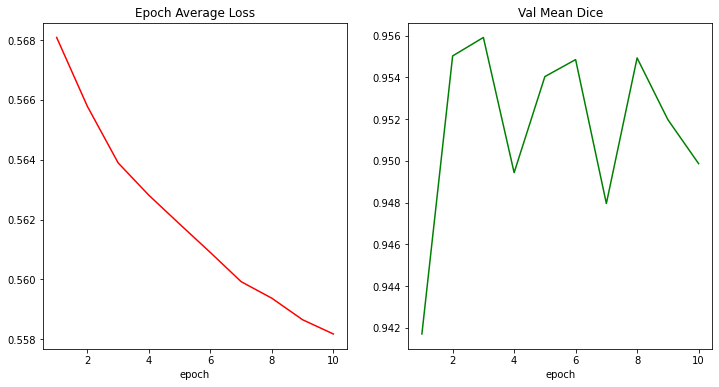

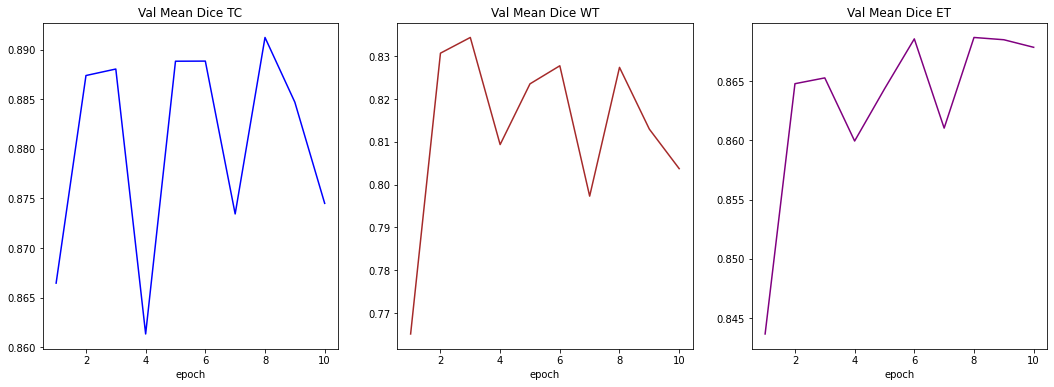

In [17]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()


torch.Size([1, 4, 240, 240])


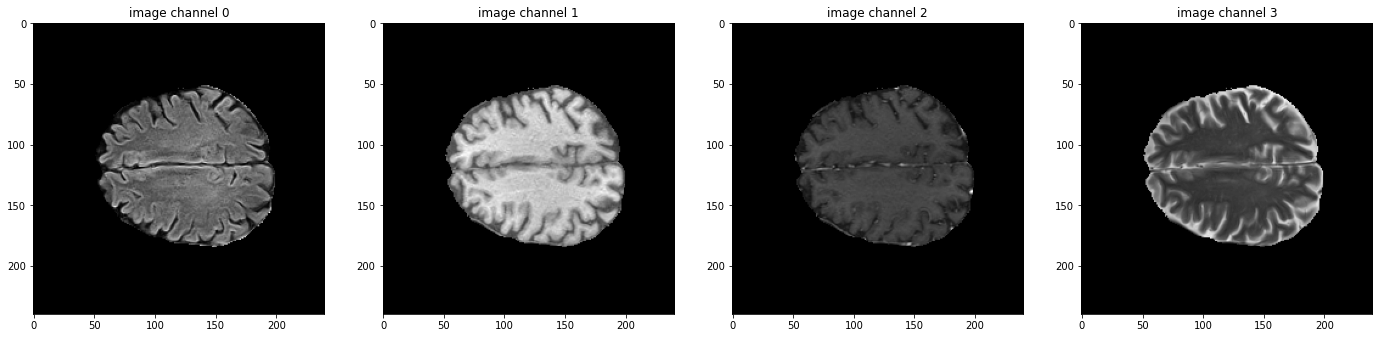

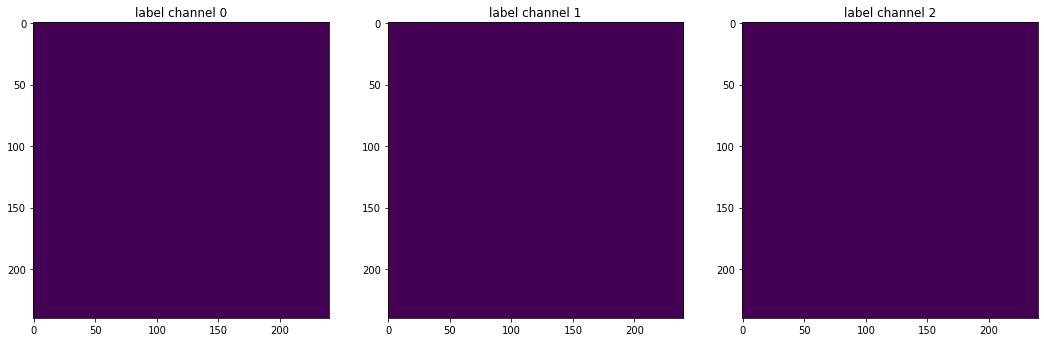

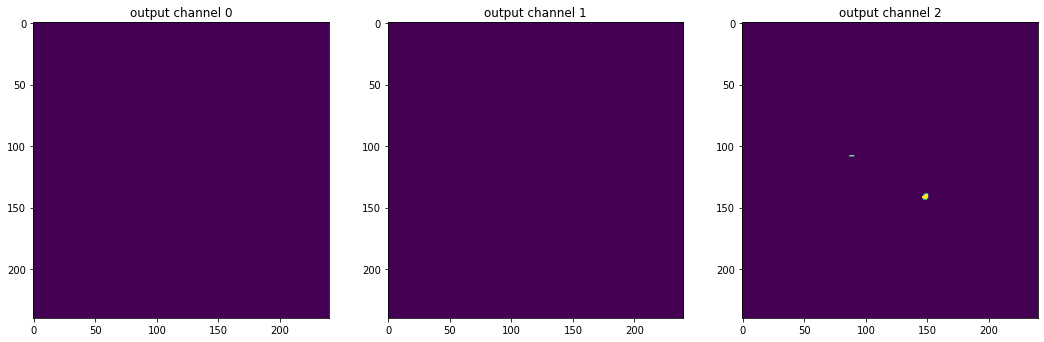

torch.Size([1, 4, 240, 240])


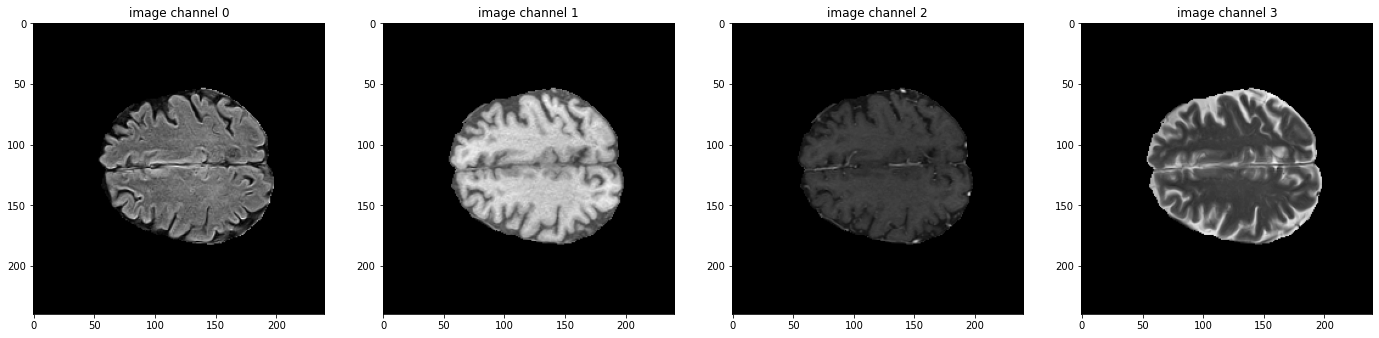

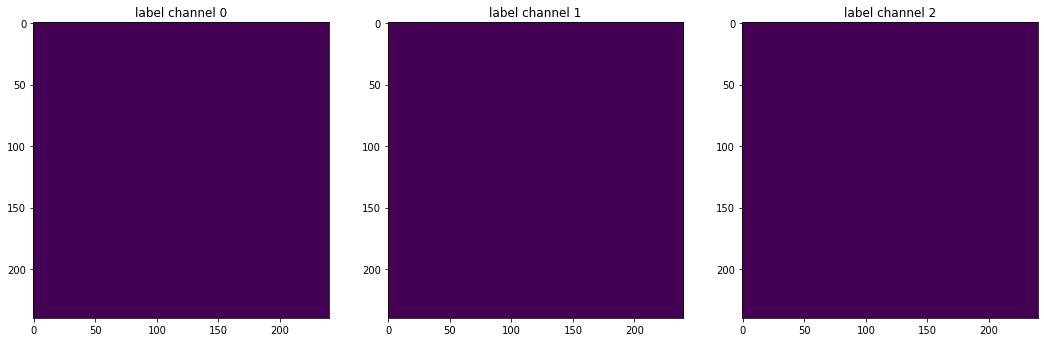

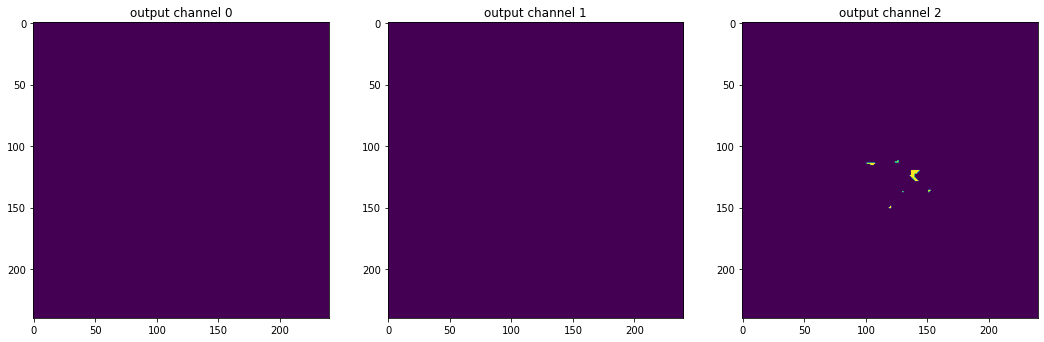

torch.Size([1, 4, 240, 240])


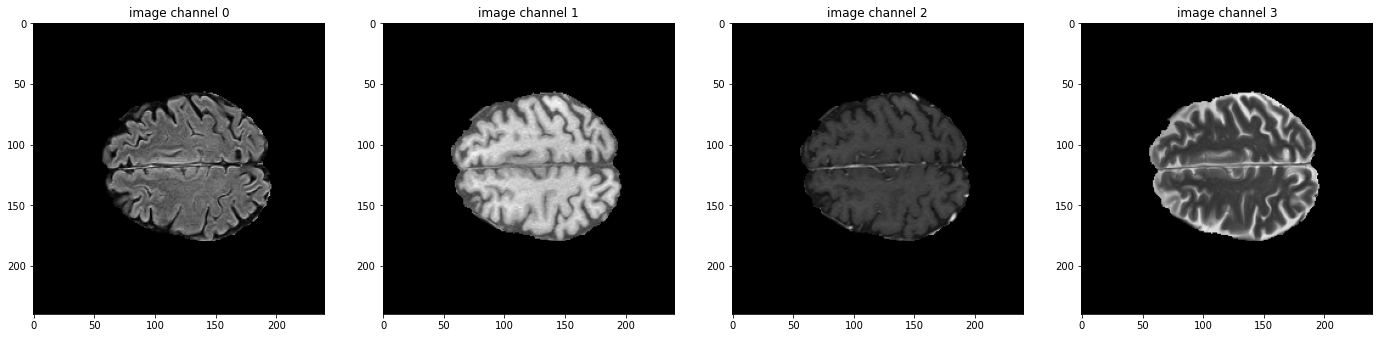

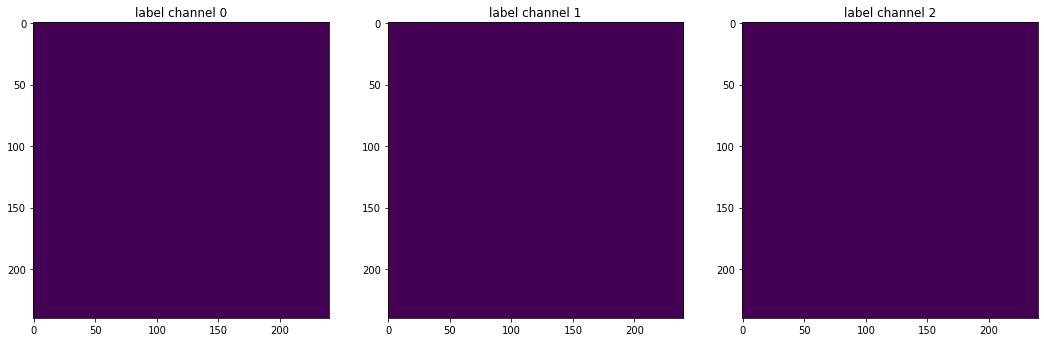

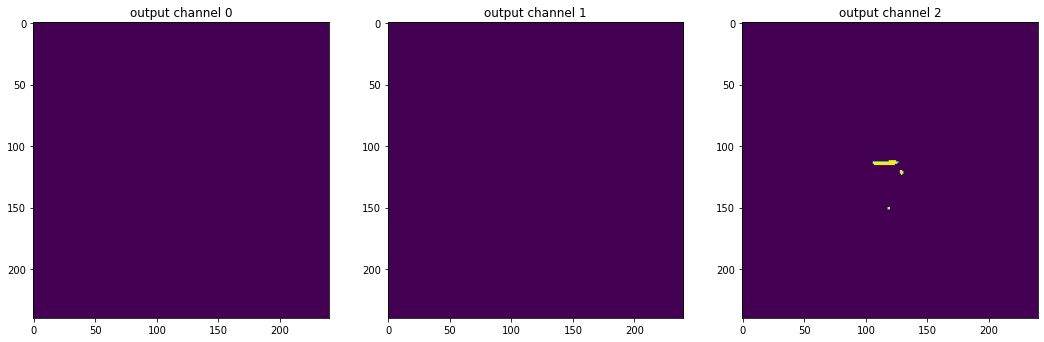

torch.Size([1, 4, 240, 240])


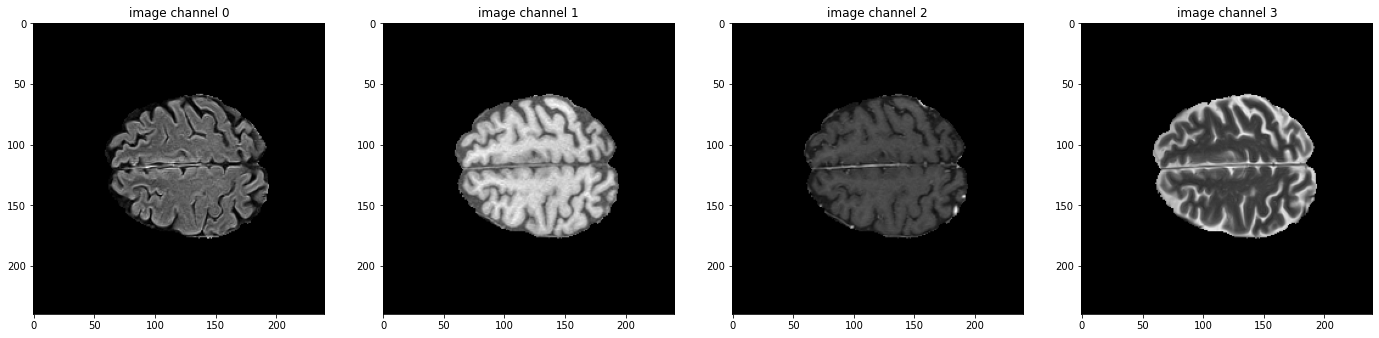

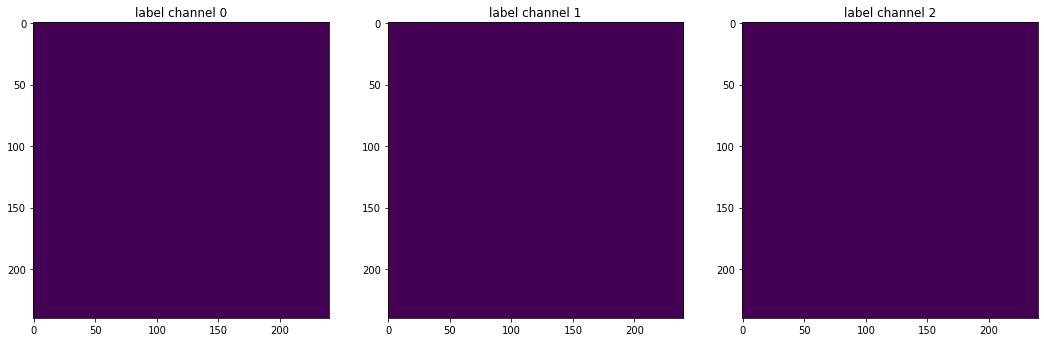

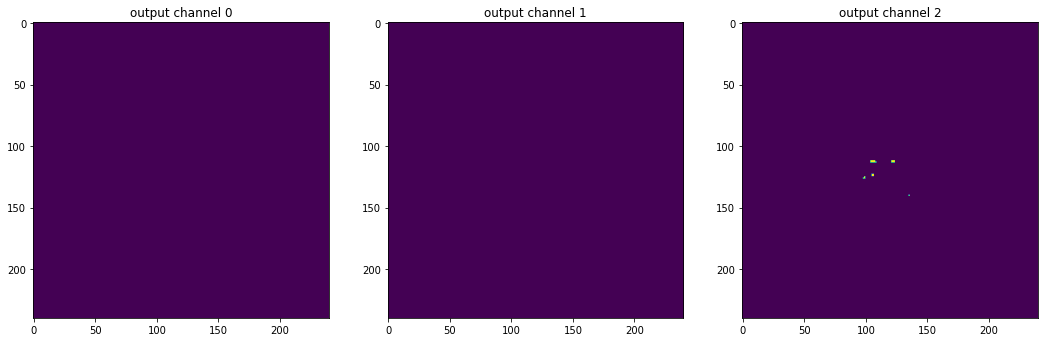

torch.Size([1, 4, 240, 240])


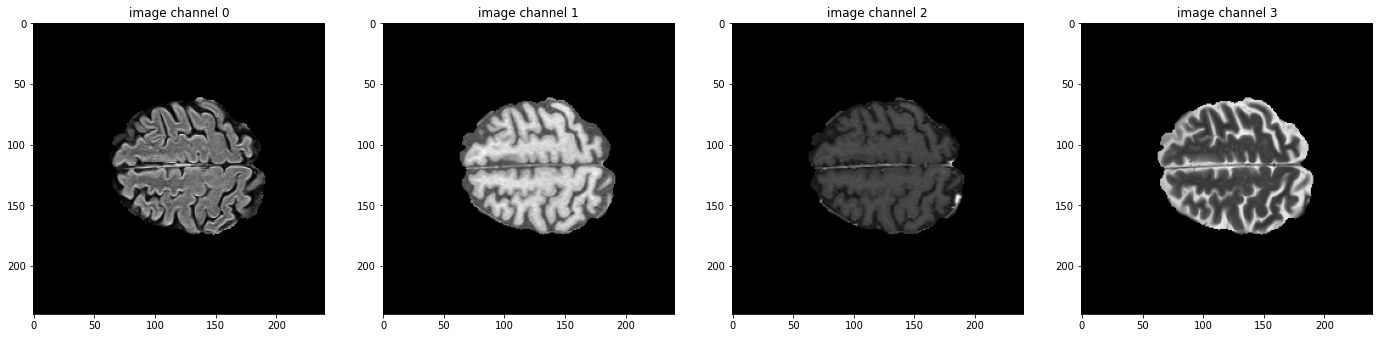

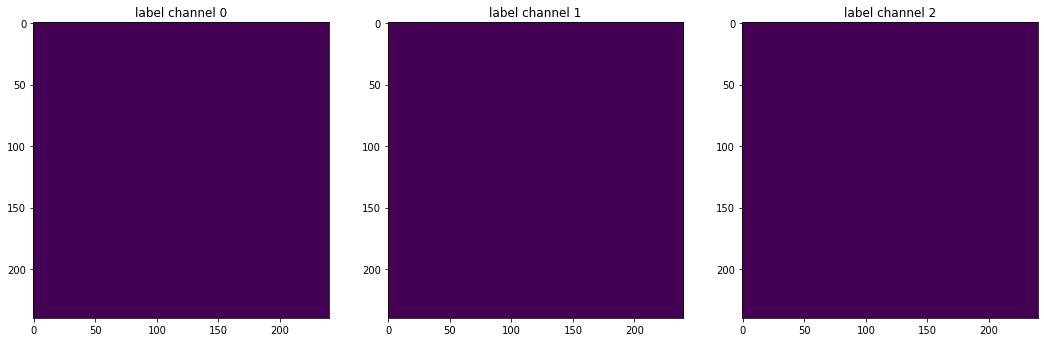

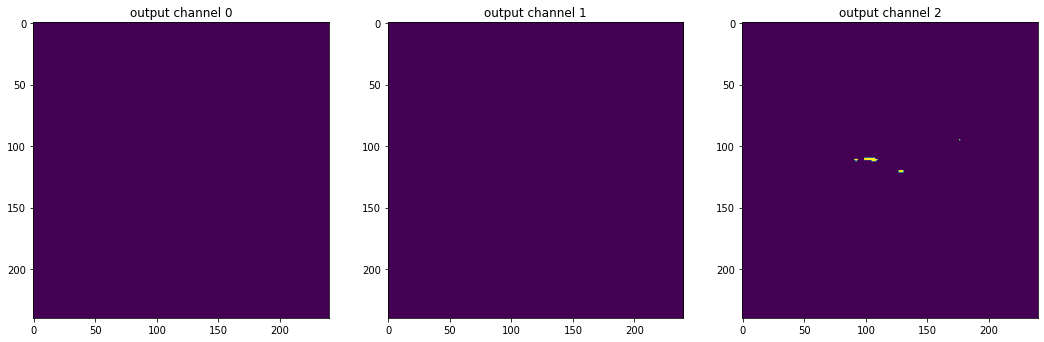

torch.Size([1, 4, 240, 240])


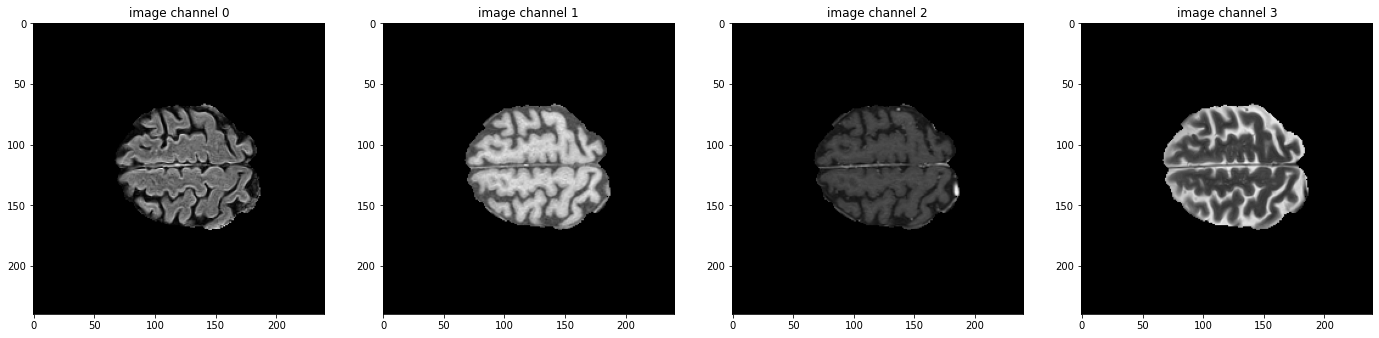

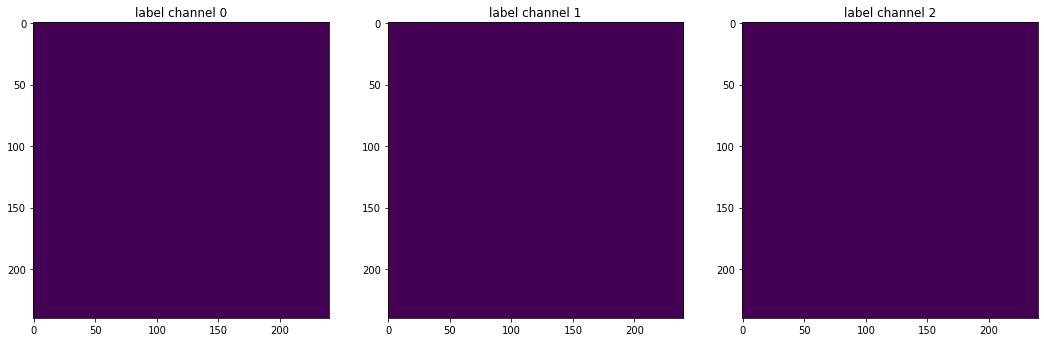

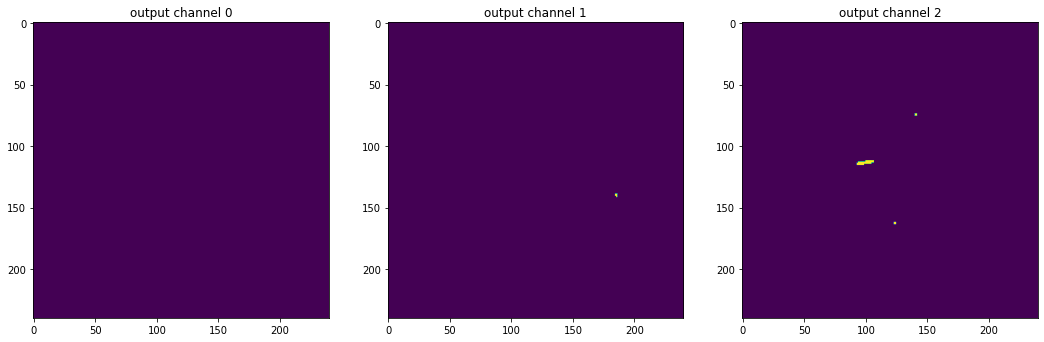

torch.Size([1, 4, 240, 240])


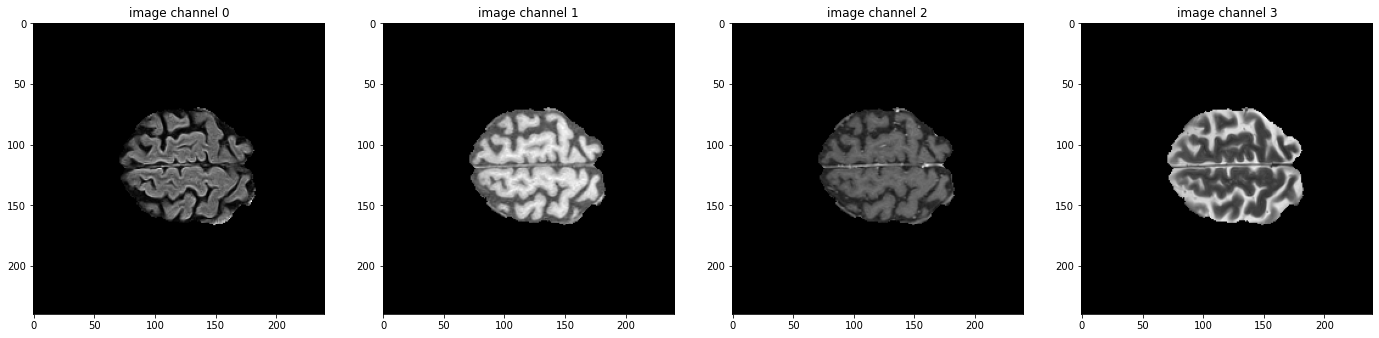

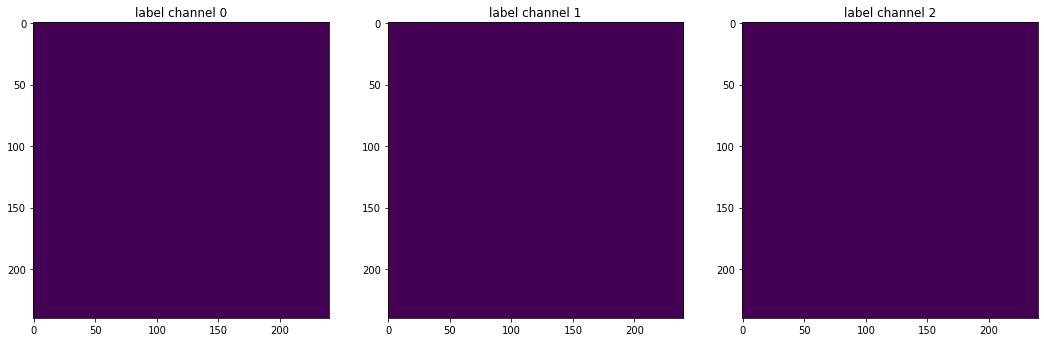

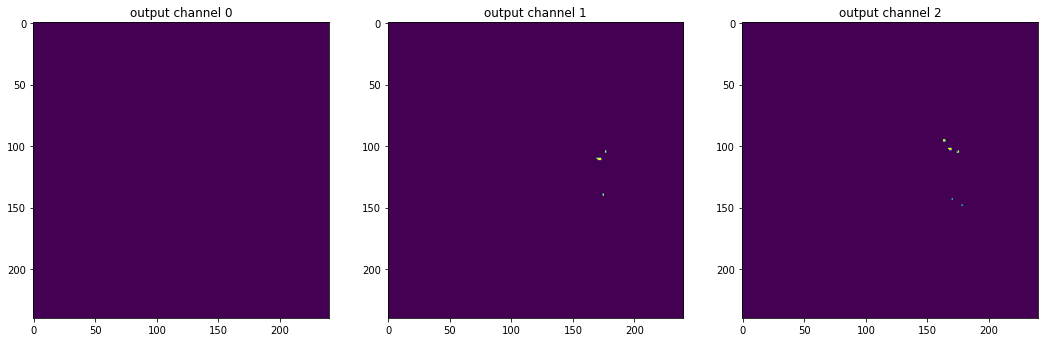

torch.Size([1, 4, 240, 240])


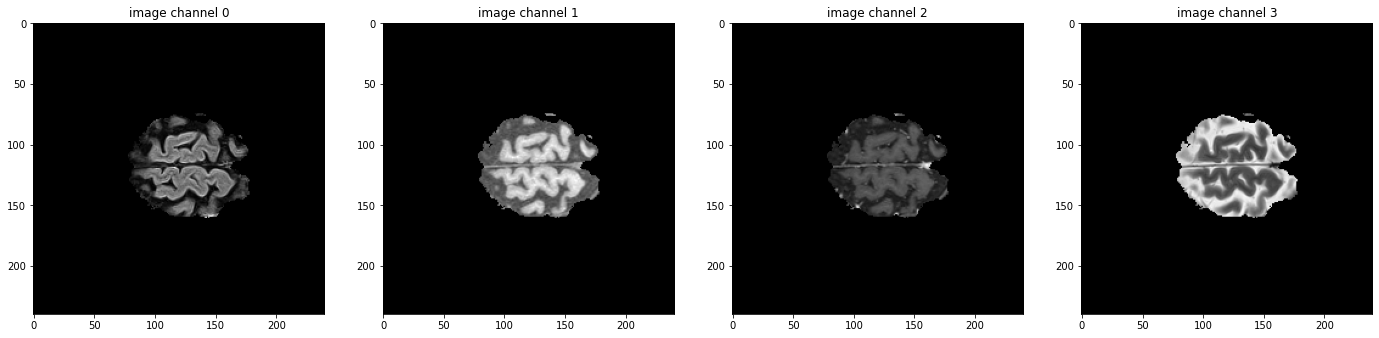

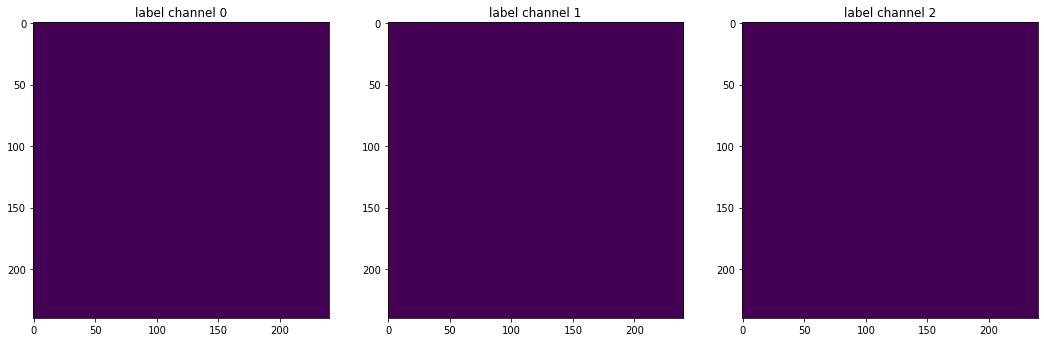

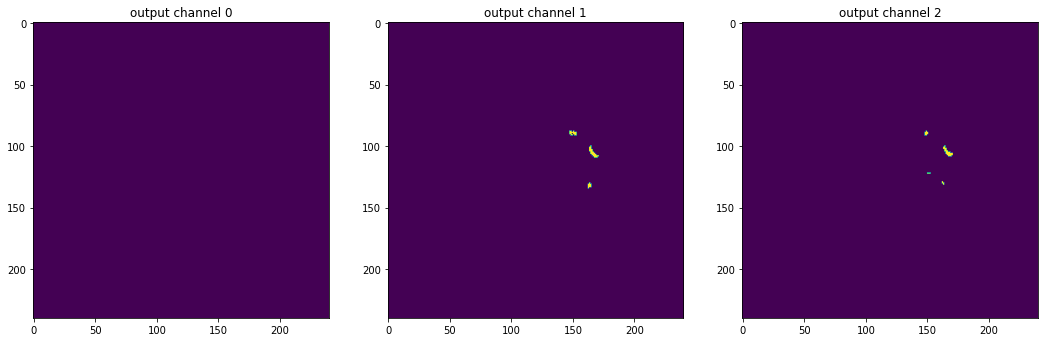

torch.Size([1, 4, 240, 240])


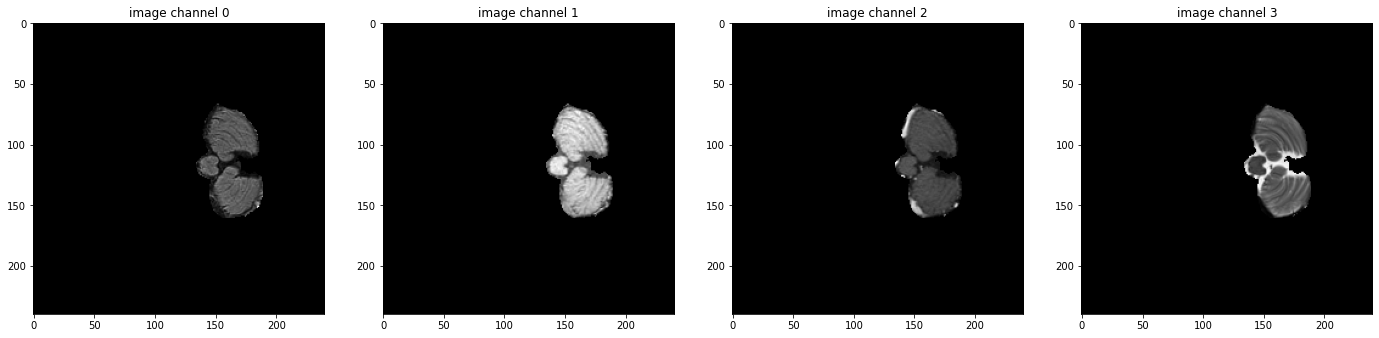

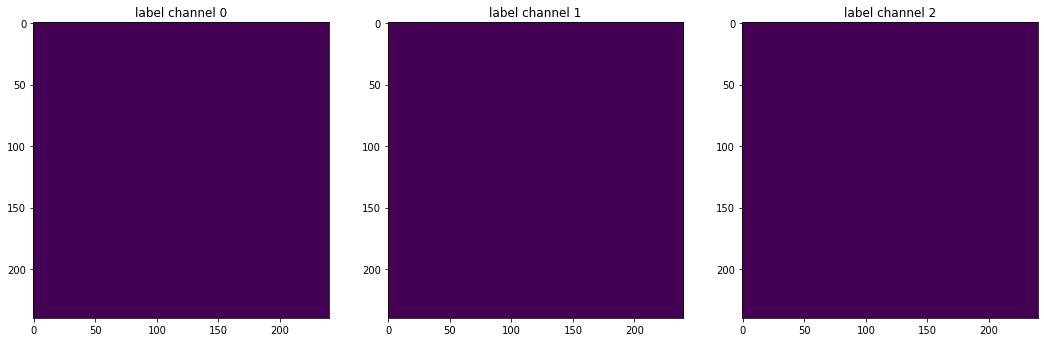

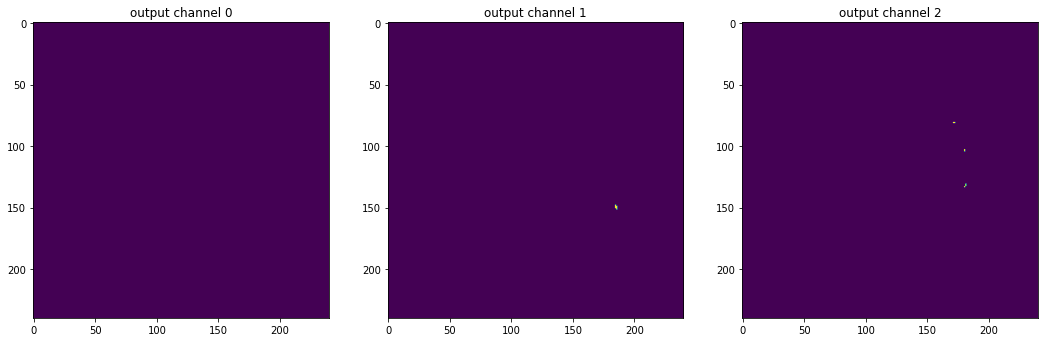

torch.Size([1, 4, 240, 240])


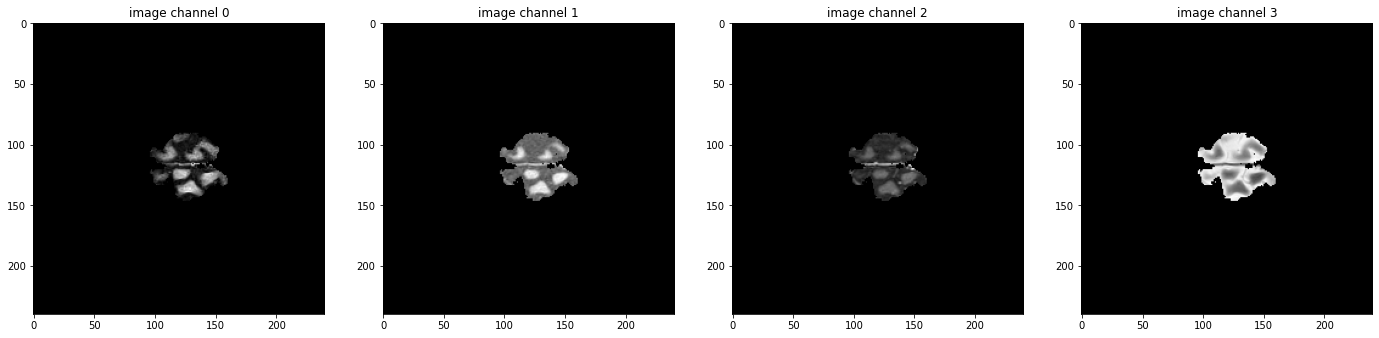

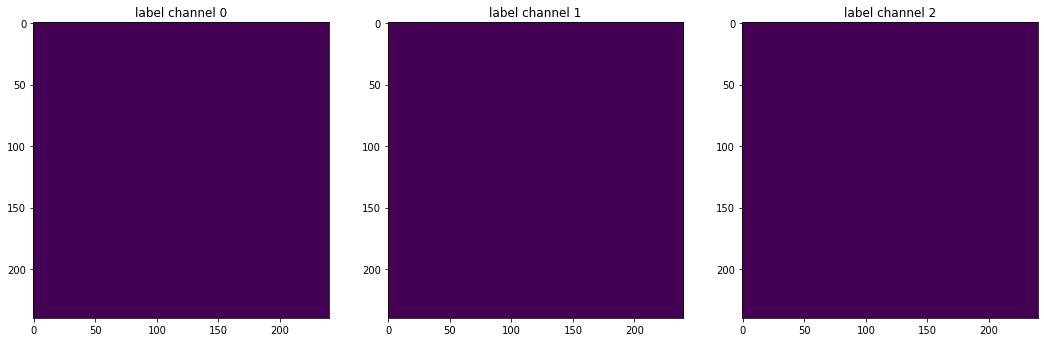

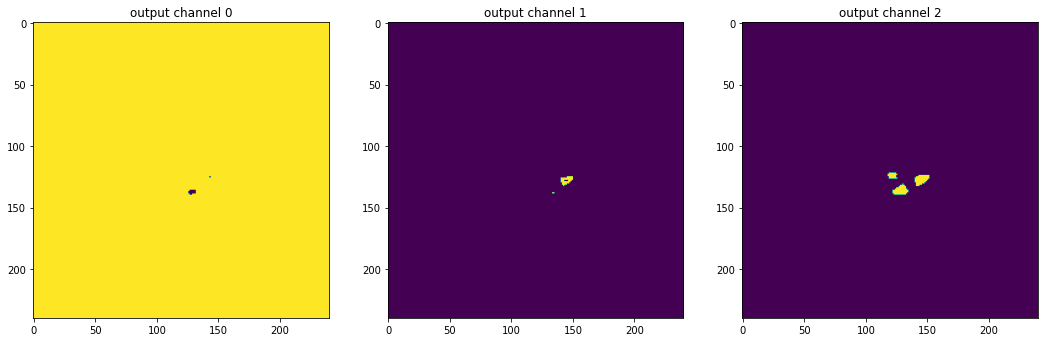

torch.Size([1, 4, 240, 240])


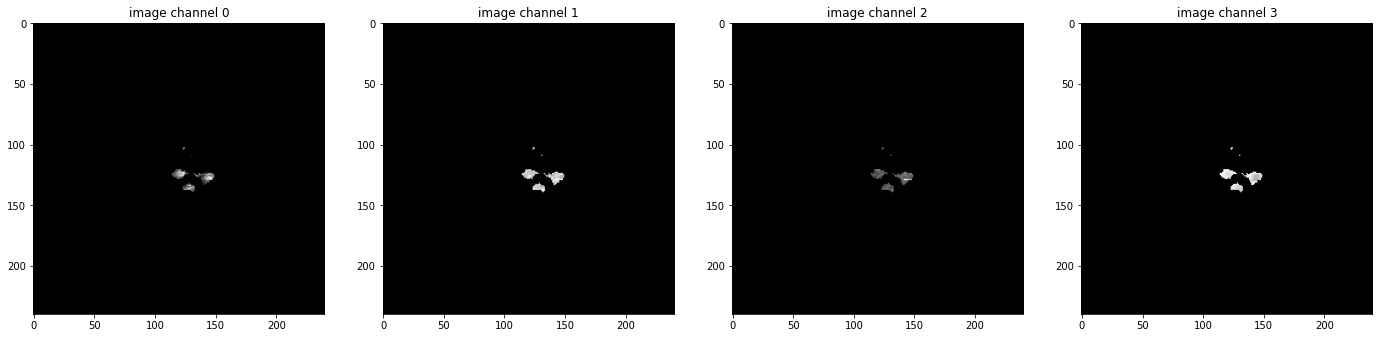

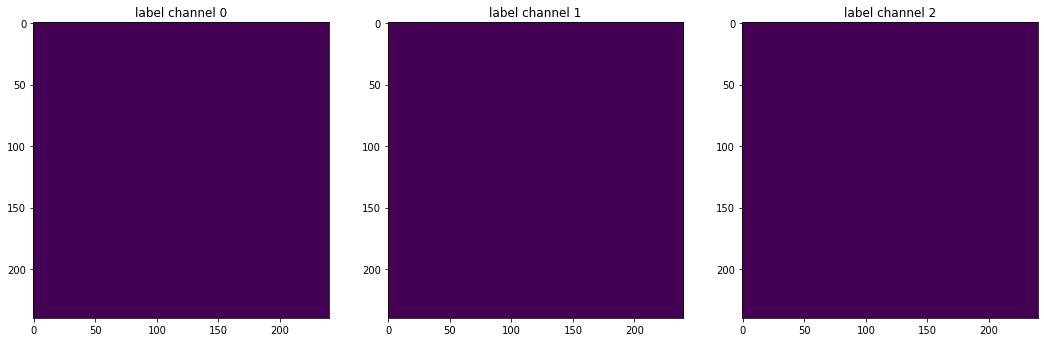

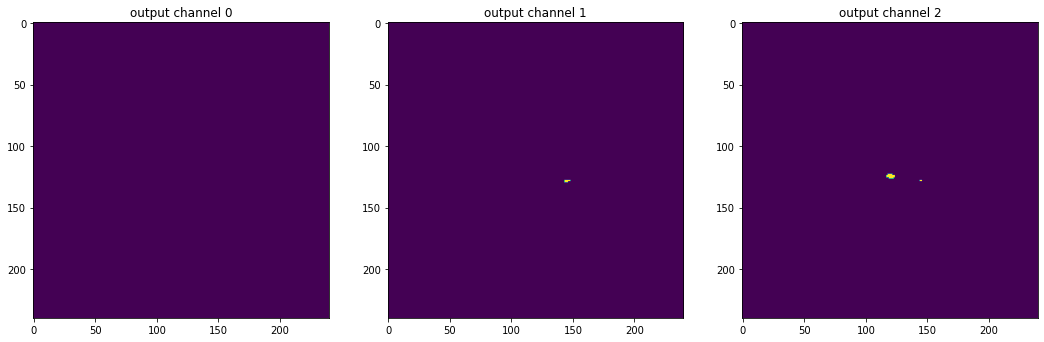

torch.Size([1, 4, 240, 240])


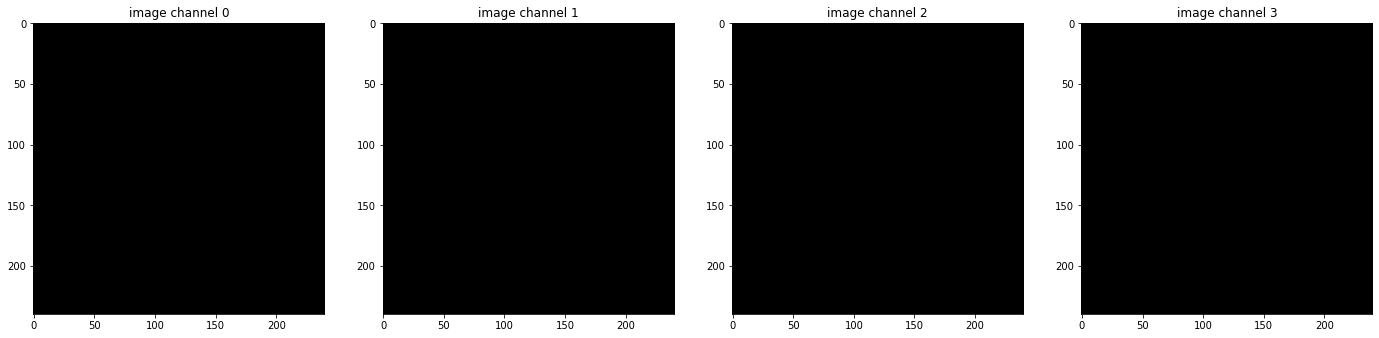

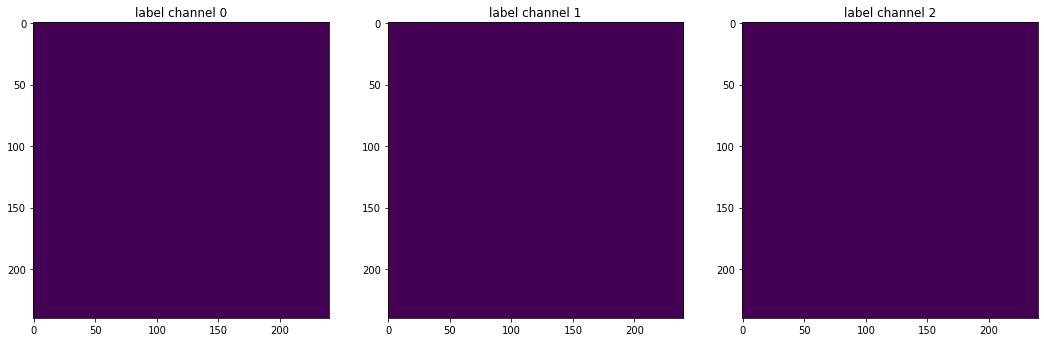

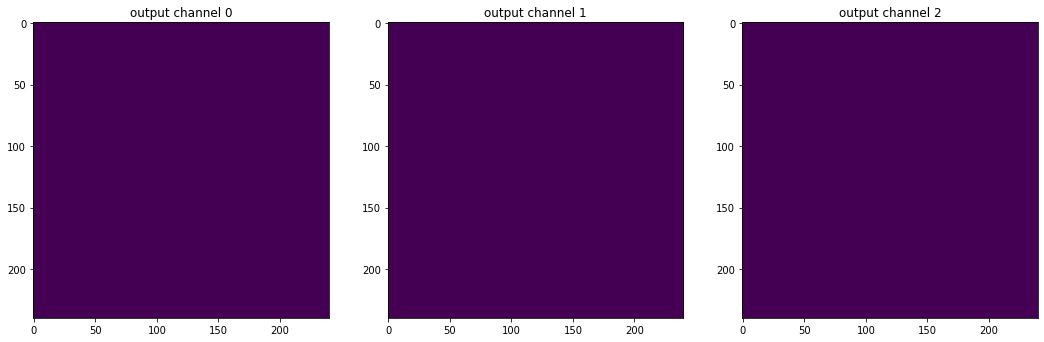

torch.Size([1, 4, 240, 240])


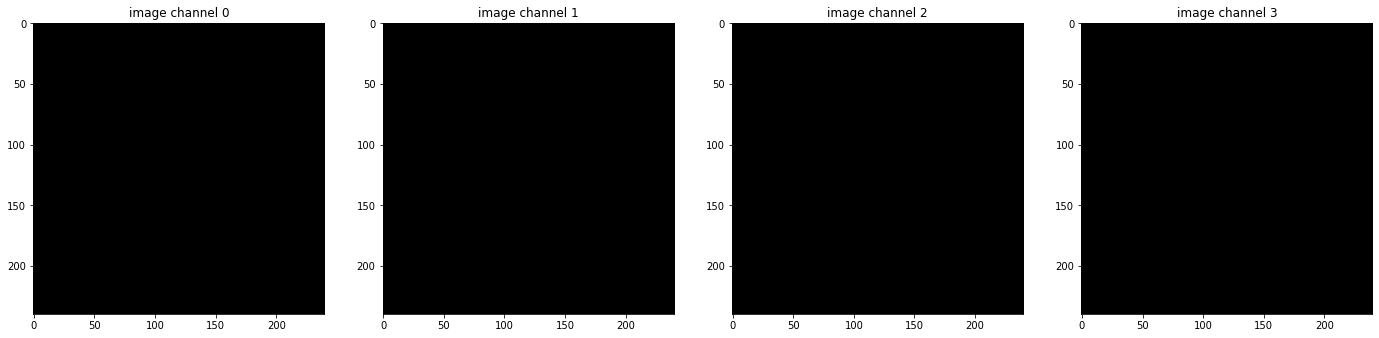

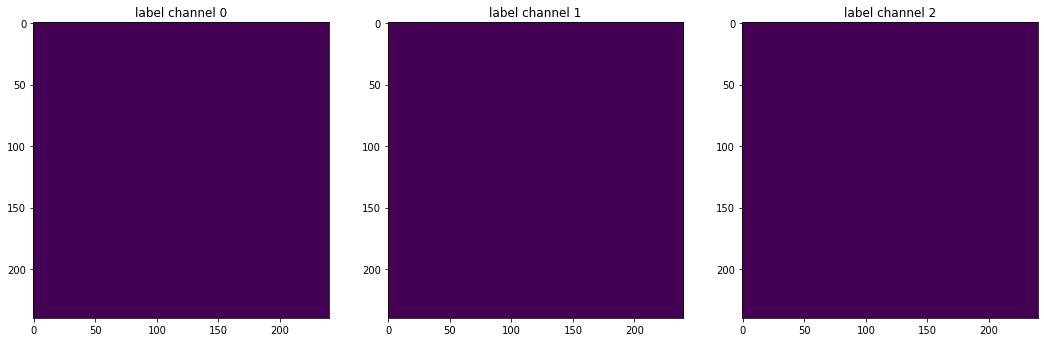

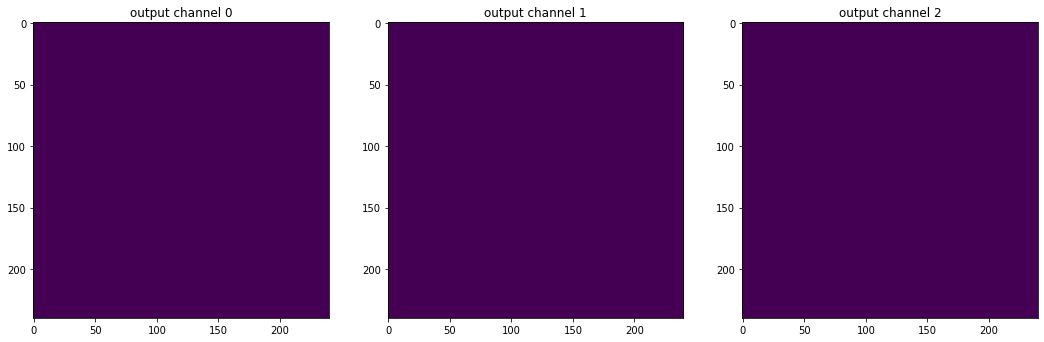

torch.Size([1, 4, 240, 240])


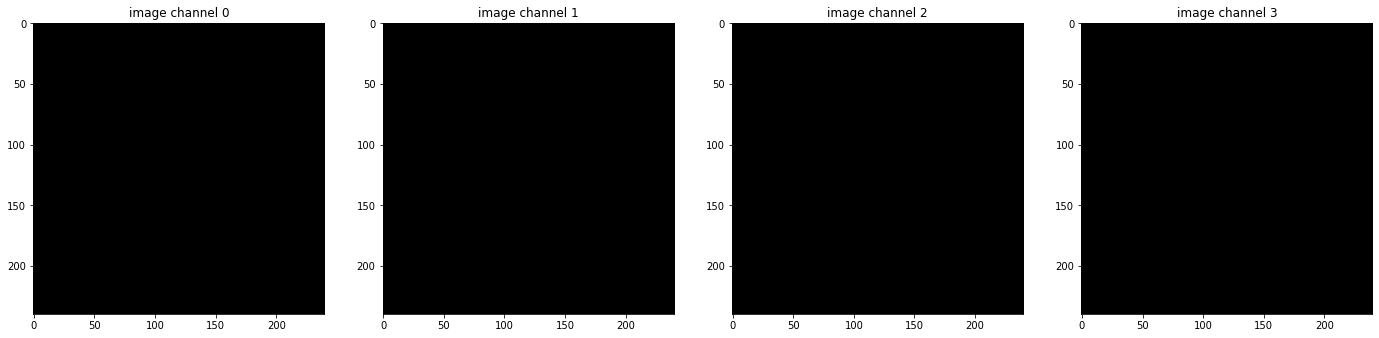

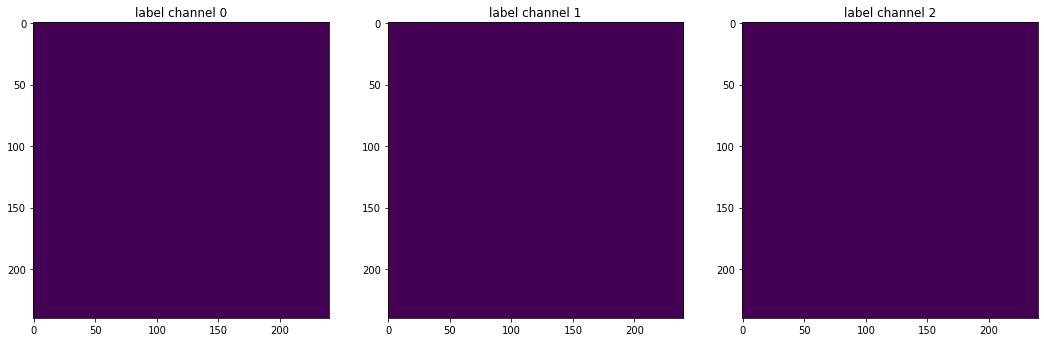

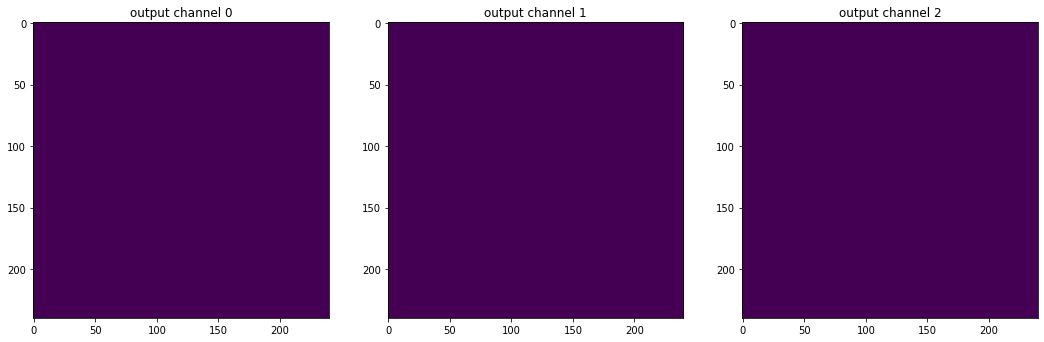

torch.Size([1, 4, 240, 240])


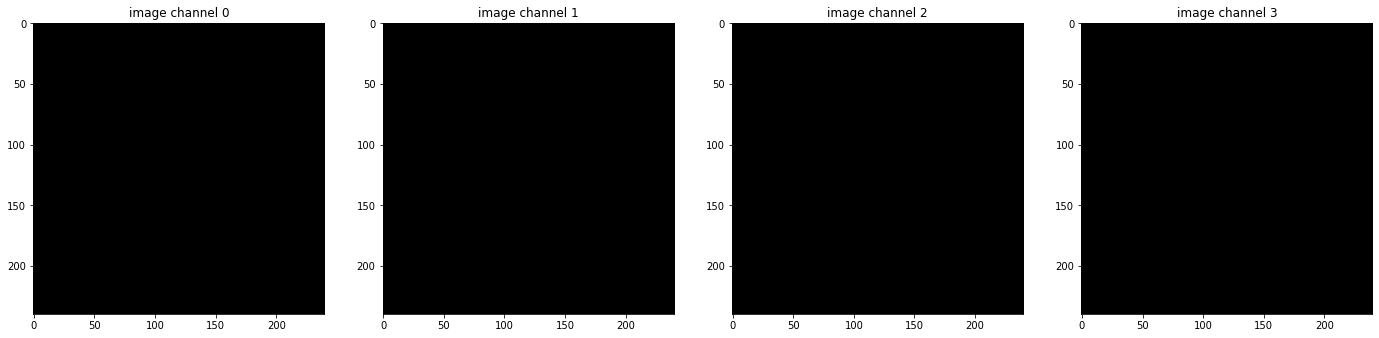

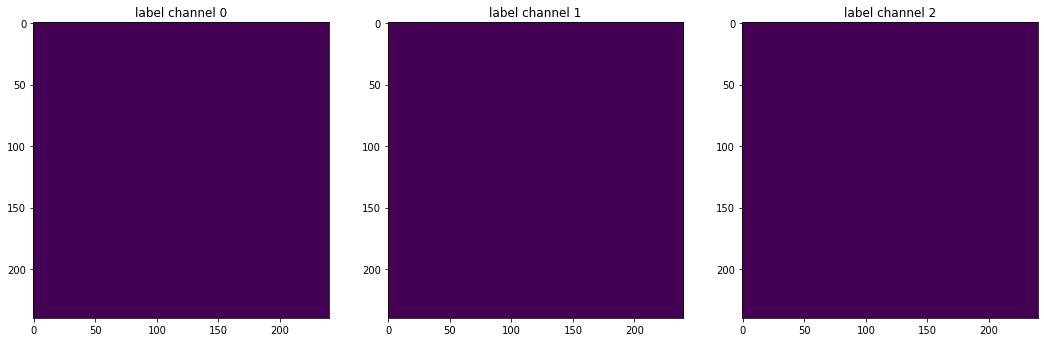

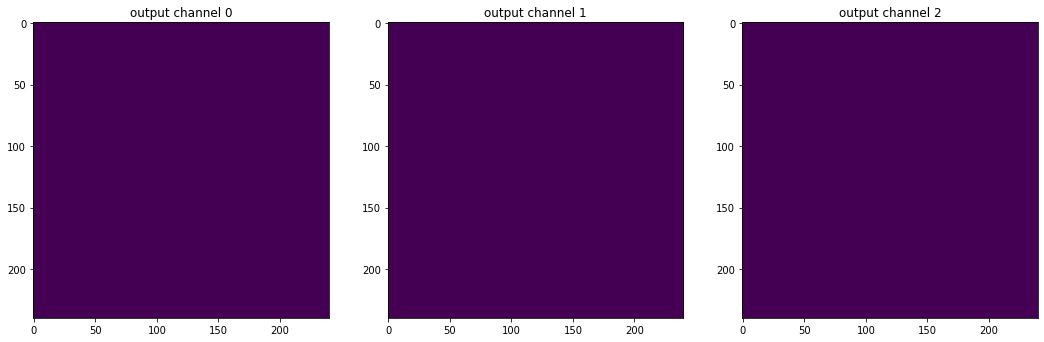

torch.Size([1, 4, 240, 240])


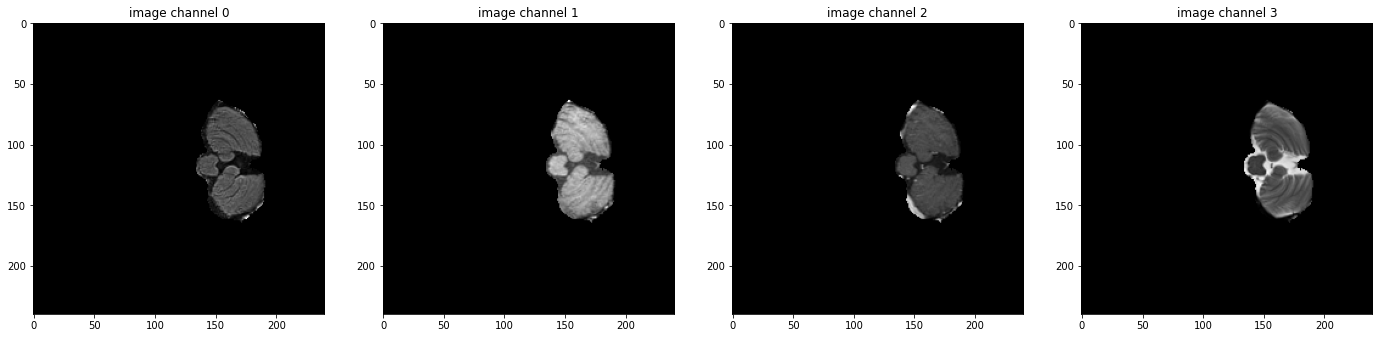

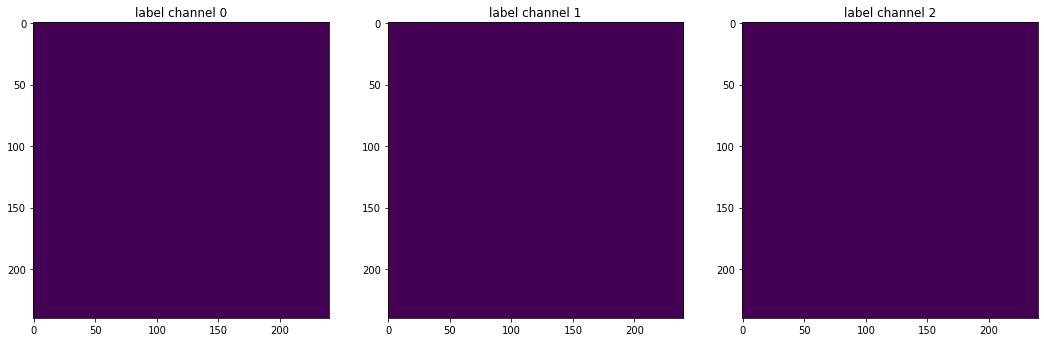

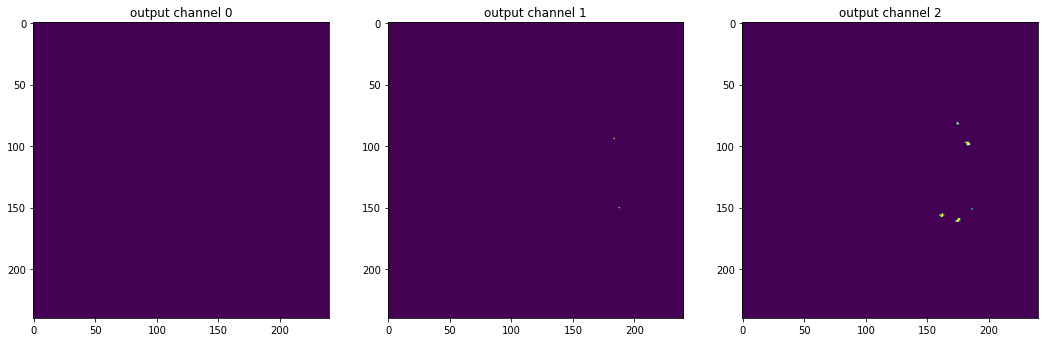

torch.Size([1, 4, 240, 240])


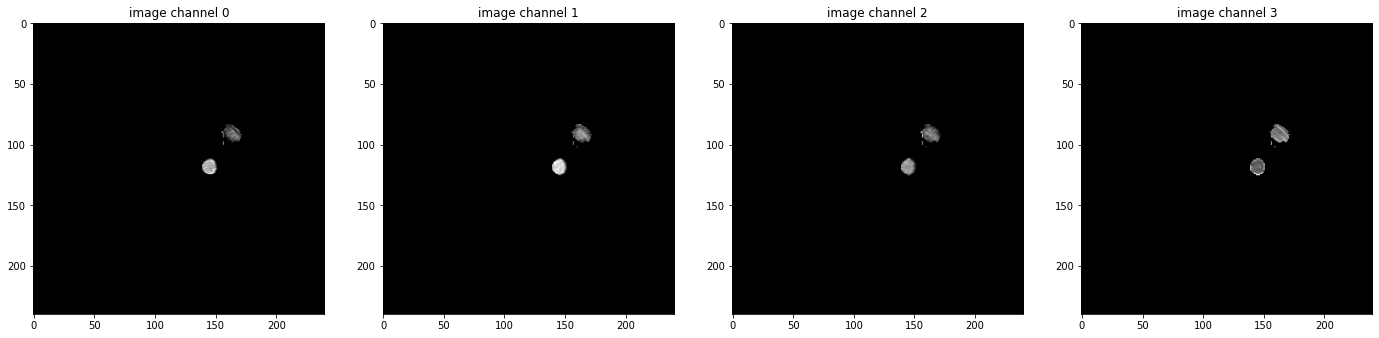

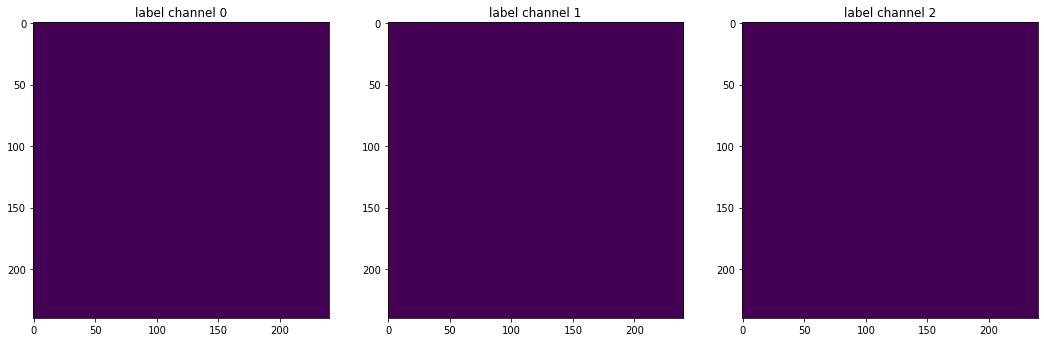

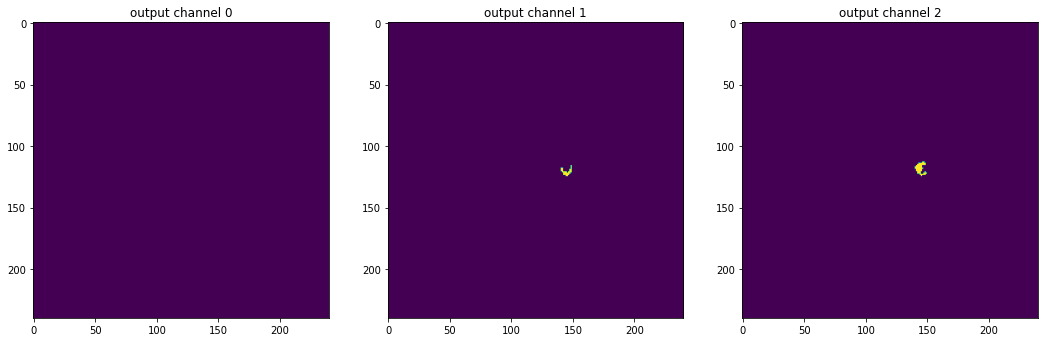

torch.Size([1, 4, 240, 240])


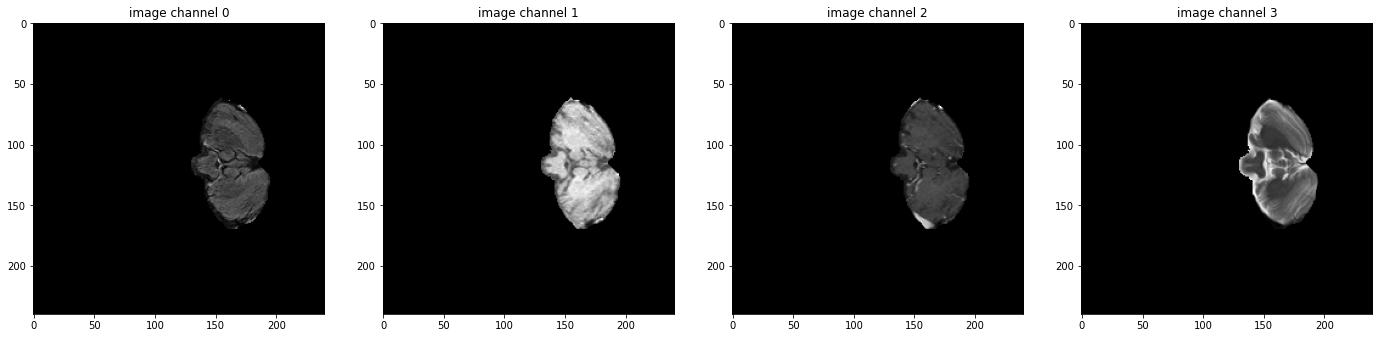

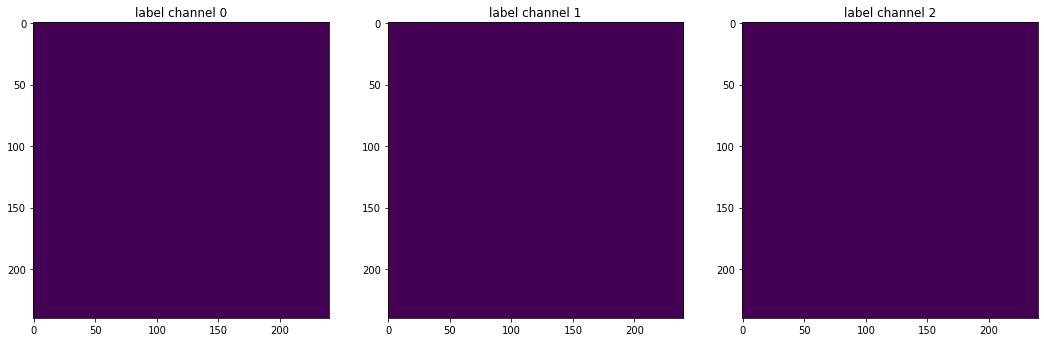

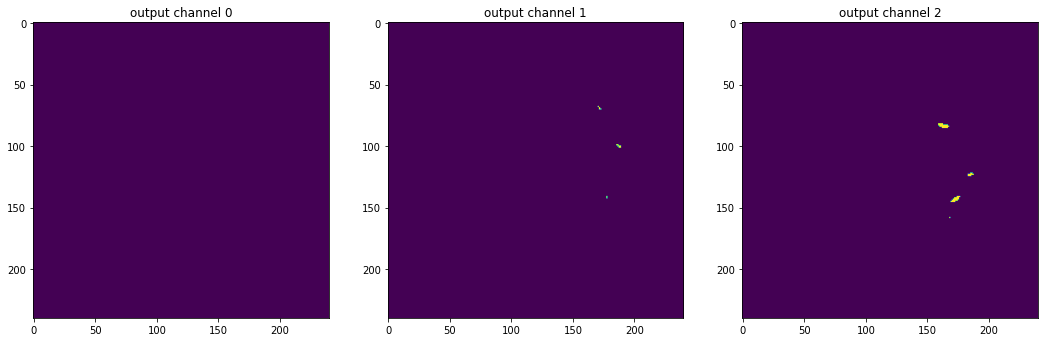

torch.Size([1, 4, 240, 240])


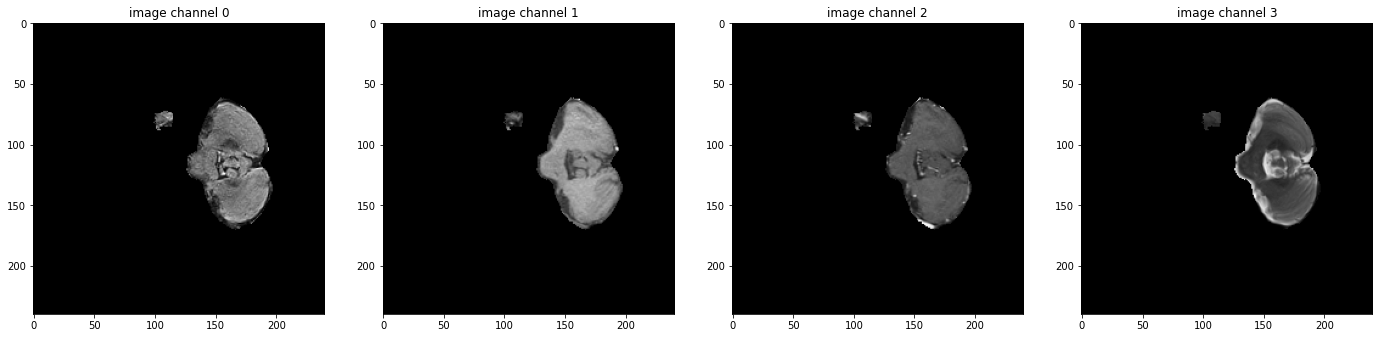

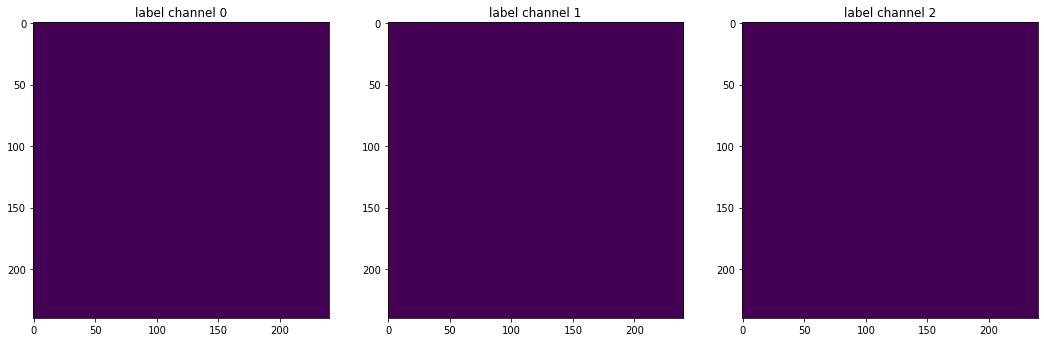

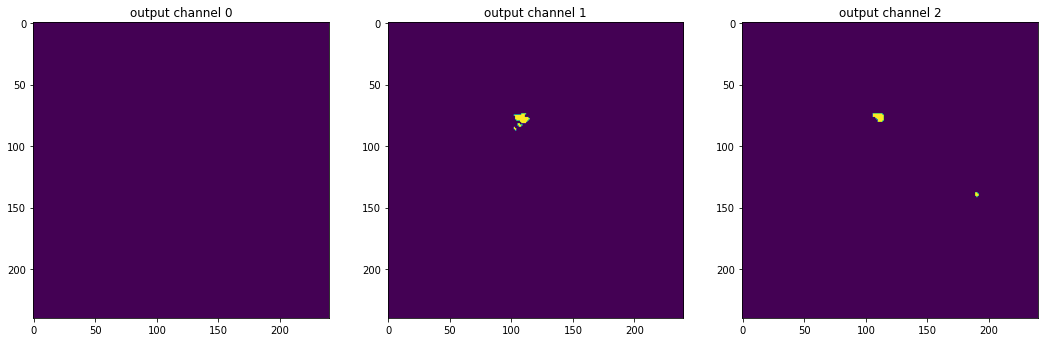

torch.Size([1, 4, 240, 240])


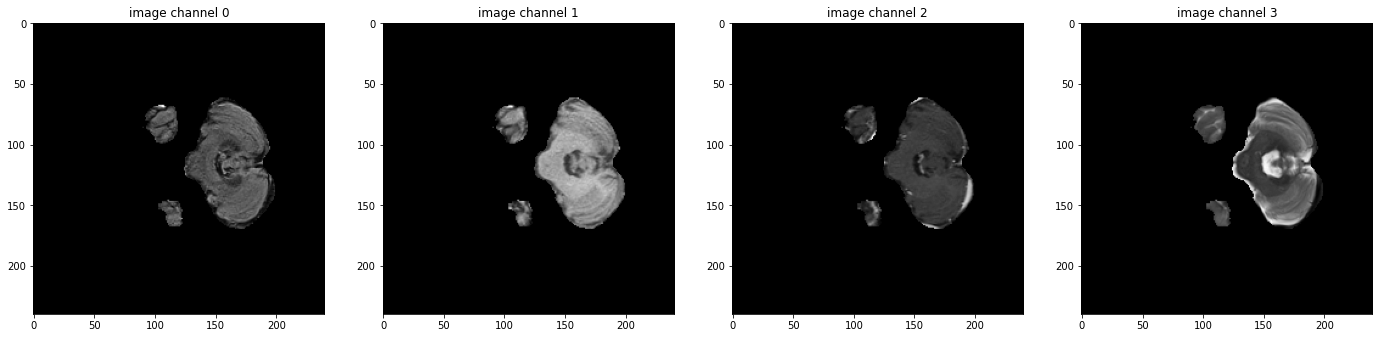

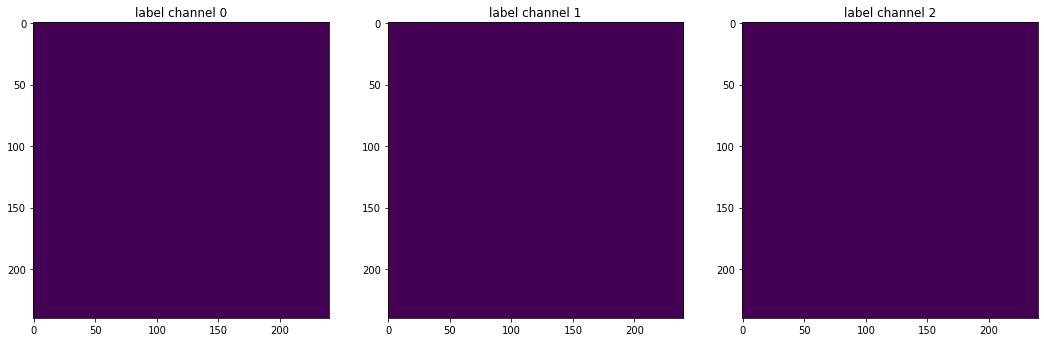

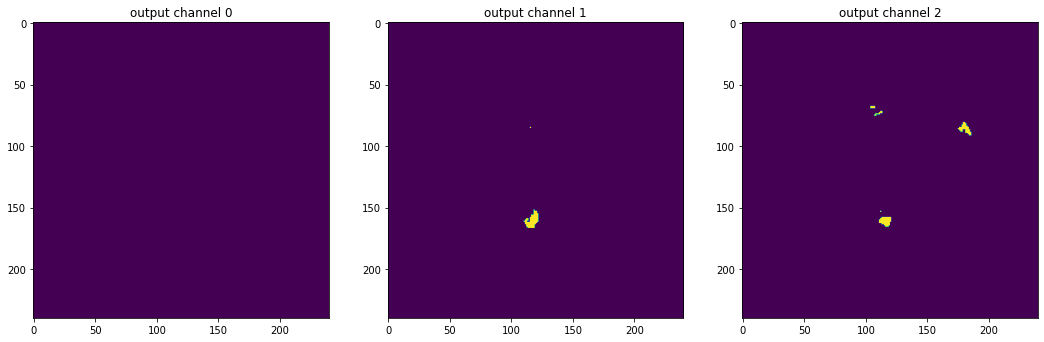

torch.Size([1, 4, 240, 240])


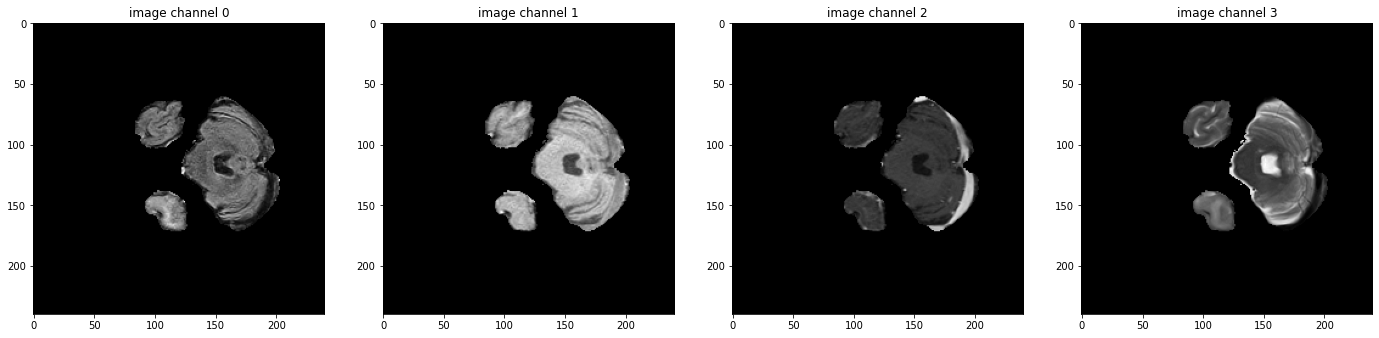

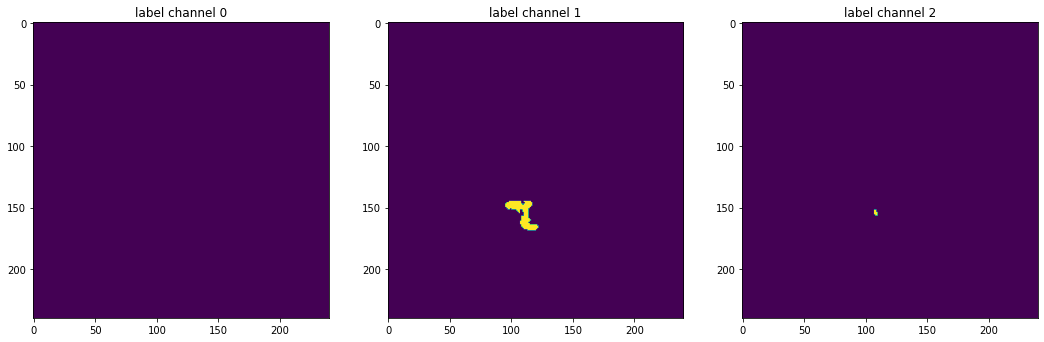

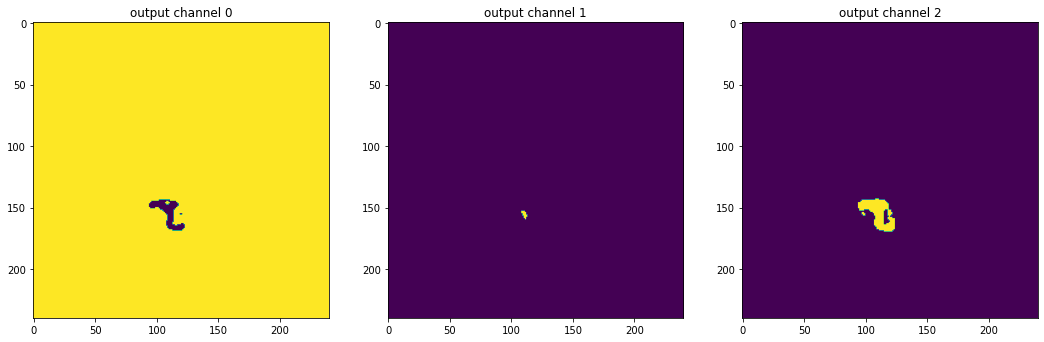

In [ ]:
model.load_state_dict(
    torch.load(os.path.join("result/best_metric_model.pth"))
)
model.eval()
with torch.no_grad():
    for idx,val_ds in enumerate(valid_dataloader):
        # select one image to evaluate and visualize the model output
        val_input = val_ds["image"][3].unsqueeze(0)
        print(val_input.shape)
        roi_size = (224,224)
        sw_batch_size = 1
        val_output = inference(val_input)
        val_output = post_trans(val_output[0])
        plt.figure("image", (24, 6))
        for i in range(4):
            plt.subplot(1, 4, i + 1)
            plt.title(f"image channel {i}")
            plt.imshow(val_ds["image"][3][i, :, :].detach().cpu(), cmap="gray")
        plt.show()
        # visualize the 3 channels label corresponding to this image
        plt.figure("label", (18, 6))
        for i in range(3):
            plt.subplot(1, 3, i + 1)
            plt.title(f"label channel {i}")
            plt.imshow(val_ds["label"][3][i, :, :].detach().cpu())
        plt.show()
        # visualize the 3 channels model output corresponding to this image
        plt.figure("output", (18, 6))
        for i in range(3):
            plt.subplot(1, 3, i + 1)
            plt.title(f"output channel {i}")
            plt.imshow(val_output[i, :, :].detach().cpu())
        plt.show()
        if idx==100:
            break;